In [ ]:
import astra

In [ ]:
print(astra.__version__)

2.3.1


In [ ]:
!pip install jupyterlab notebook
!pip install cupy-cuda11x
!pip install torch

In [ ]:
import torch

In [ ]:
# Method 1: Check with nvidia-smi (if installed)
!nvidia-smi

Mon Jun 16 10:12:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 553.35                 Driver Version: 553.35         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000             WDDM  |   00000000:18:00.0  On |                  Off |
| 41%   46C    P8             12W /  140W |     531MiB /  16376MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
'''import cupy as cp

# Create a large array on GPU
a = cp.random.rand(10000, 10000)
b = cp.dot(a, a.T)

# Move result to CPU and print shape
print(cp.asnumpy(b).shape)'''
import astra
astra.clear()

In [ ]:
import numpy as np
import astra
import random
from scipy.sparse import csr_matrix
import pandas as pd

def generate_random_geometry_params():
    """Generate random CT geometry parameters within realistic ranges"""
    params = {
        'num_detectors': random.randint(256, 512),
        'num_angles': random.randint(360, 720),
        'image_size': random.randint(64, 256),
        'source_to_center': random.uniform(800, 1200),  # mm
        'center_to_detector': random.uniform(300, 700),  # mm
        'detector_spacing': random.uniform(0.5, 2.0)    # mm
    }
    return params

def create_fanbeam_geometry(params):
    """Create ASTRA fanbeam geometry from parameters"""
    # Calculate source-to-detector distance
    source_to_detector = params['source_to_center'] + params['center_to_detector']

    # Create projection geometry (fan beam)
    angles = np.linspace(0, 2*np.pi, params['num_angles'], False)
    proj_geom = astra.create_proj_geom('fanflat',
                                       params['detector_spacing'],
                                       params['num_detectors'],
                                       angles,
                                       params['source_to_center'],
                                       params['center_to_detector'])

    # Create volume geometry (reconstruction grid)
    vol_geom = astra.create_vol_geom(params['image_size'], params['image_size'])

    return proj_geom, vol_geom

def generate_system_matrix(proj_geom, vol_geom):
    """Generate the system matrix using ASTRA"""
    # Create projector
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)

    # Get the system matrix
    matrix_id = astra.projector.matrix(proj_id)
    system_matrix = astra.matrix.get(matrix_id)

    # Clean up ASTRA objects
    astra.matrix.delete(matrix_id)
    astra.projector.delete(proj_id)
    astra.clear()

    return system_matrix

def calculate_sparsity(matrix):
    """Calculate sparsity of the system matrix"""
    if hasattr(matrix, 'nnz'):  # Sparse matrix
        total_elements = matrix.shape[0] * matrix.shape[1]
        non_zero_elements = matrix.nnz
    else:  # Dense matrix
        total_elements = matrix.size
        non_zero_elements = np.count_nonzero(matrix)

    sparsity = 1.0 - (non_zero_elements / total_elements)
    return sparsity, non_zero_elements, total_elements

def process_single_geometry(params):
    """Process a single geometry configuration and return results"""
    try:
        # Create geometry
        proj_geom, vol_geom = create_fanbeam_geometry(params)

        # Generate system matrix
        system_matrix = generate_system_matrix(proj_geom, vol_geom)

        # Calculate sparsity
        sparsity, nnz, total = calculate_sparsity(system_matrix)

        # Prepare results
        results = params.copy()
        results.update({
            'sparsity': sparsity,
            'non_zero_elements': nnz,
            'total_elements': total,
            'matrix_shape': system_matrix.shape
        })

        #print(f"Geometry processed:")
        #print(f"  Detectors: {params['num_detectors']}, Angles: {params['num_angles']}")
        #print(f"  Image size: {params['image_size']}x{params['image_size']}")
        #print(f"  Source-center: {params['source_to_center']:.1f}mm")
        #print(f"  Center-detector: {params['center_to_detector']:.1f}mm")
        #print(f"  Detector spacing: {params['detector_spacing']:.2f}mm")
        #print(f"  System matrix shape: {system_matrix.shape}")
        #print(f"  Sparsity: {sparsity:.4f} ({sparsity*100:.2f}%)")
        #print(f"  Non-zero elements: {nnz:,} / {total:,}")
        #print("-" * 50)

        return results

    except Exception as e:
        print(f"Error processing geometry: {e}")
        return None

def generate_dataset(num_samples=10):
    """Generate a dataset of geometries and their corresponding sparsities"""
    results = []

    print("Generating CT system matrices and calculating sparsities...")
    print("=" * 50)

    for i in range(num_samples):
        if (i+1)%10 == 0:
            print(f"Processing sample number {i+1}/{num_samples}")

        # Generate random parameters
        params = generate_random_geometry_params()

        # Process geometry
        result = process_single_geometry(params)

        if result is not None:
            results.append(result)

    return results

def save_results(results, filename='ct_sparsity_dataset.csv'):
    """Save results to CSV file"""
    if results:
        df = pd.DataFrame(results)
        df.to_csv(filename, index=False)
        print(f"\nDataset saved to {filename}")
        print(f"Dataset shape: {df.shape}")
        #print("\nDataset summary:")
        #print(df.describe())
    else:
        print("No results to save")

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Generate dataset
    num_samples = 1000  # Adjust as needed
    results = generate_dataset(num_samples)

    # Save results
    save_results(results)

    # Example: Process a single specific geometry
    '''print("\n" + "="*60)
    print("Example with specific geometry parameters:")
    specific_params = {
        'num_detectors': 512,
        'num_angles': 360,
        'image_size': 256,
        'source_to_center': 1000.0,
        'center_to_detector': 500.0,
        'detector_spacing': 1.0
    }

    specific_result = process_single_geometry(specific_params)'''

    # Clean up ASTRA
    astra.clear()

Generating CT system matrices and calculating sparsities...
Processing sample number 10/1000
Processing sample number 20/1000
Processing sample number 30/1000
Processing sample number 40/1000
Processing sample number 50/1000
Processing sample number 60/1000
Processing sample number 70/1000
Processing sample number 80/1000
Processing sample number 90/1000
Processing sample number 100/1000
Processing sample number 110/1000
Processing sample number 120/1000
Processing sample number 130/1000
Processing sample number 140/1000
Processing sample number 150/1000
Processing sample number 160/1000
Processing sample number 170/1000
Processing sample number 180/1000
Processing sample number 190/1000
Processing sample number 200/1000
Processing sample number 210/1000
Processing sample number 220/1000
Processing sample number 230/1000
Processing sample number 240/1000
Processing sample number 250/1000
Processing sample number 260/1000
Processing sample number 270/1000
Processing sample number 280/10

In [ ]:
ct_sparsity_df = pd.read_csv('ct_sparsity_dataset.csv')

In [ ]:
ct_sparsity_df.head(10)

,num_detectors,num_angles,image_size,source_to_center,center_to_detector,detector_spacing,sparsity,non_zero_elements,total_elements,matrix_shape
0,313,372,253,910.011727,389.284295,1.604707,0.996346,27232194,7452951924,"(116436, 64009)"
1,300,662,172,812.713072,337.478096,0.848991,0.993216,39856354,5875382400,"(198600, 29584)"
2,269,647,114,1086.407845,580.529989,1.129280,0.993560,14566084,2261862828,"(174043, 12996)"
3,485,661,135,1123.772183,302.599504,1.708729,0.998046,11414784,5842661625,"(320585, 18225)"
4,472,534,135,862.191800,682.885229,1.004892,0.995175,22166063,4593574800,"(252048, 18225)"
5,303,554,88,943.591752,437.582289,0.896781,0.993134,8925108,1299923328,"(167862, 7744)"
6,278,595,201,849.930465,668.918149,0.618200,0.993077,46267069,6682729410,"(165410, 40401)"
7,406,681,222,1154.180699,444.654010,0.788433,0.994730,71817323,13626336024,"(276486, 49284)"
8,291,383,233,891.159310,415.755185,0.619688,0.994075,35850613,6050671917,"(111453, 54289)"
9,375,411,161,911.189441,554.273778,1.047248,0.994765,20913804,3995074125,"(154125, 25921)"


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# For modeling (if needed)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#removing unwanted or derived features
df_clean = ct_sparsity_df.drop(columns=['non_zero_elements', 'total_elements', 'matrix_shape'])

#separating the input features and the output label
X = df_clean.drop(columns=['sparsity'])
y = df_clean['sparsity']

# Scale only input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optionally convert back to DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_df = pd.DataFrame(y, columns=["sparsity"])

In [ ]:
X_scaled_df.describe()

,num_detectors,num_angles,image_size,source_to_center,center_to_detector,detector_spacing
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,3.517187e-16,-9.237056e-17,1.154632e-16,1.022293e-15,-1.536549e-16,3.819167e-16
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.709300e+00,-1.744468e+00,-1.739967e+00,-1.740258e+00,-1.800638e+00,-1.791054e+00
25%,-8.900875e-01,-9.162171e-01,-8.638734e-01,-8.503557e-01,-8.047096e-01,-8.292928e-01
50%,-1.626136e-02,5.959600e-02,-1.473635e-02,-2.480698e-02,-4.809058e-02,-3.590118e-02
75%,8.985254e-01,8.759470e-01,8.478791e-01,8.613711e-01,8.673205e-01,8.451544e-01
max,1.786005e+00,1.682778e+00,1.710495e+00,1.734561e+00,1.726383e+00,1.762335e+00


In [ ]:
y_df.describe()

,sparsity
count,1000.000000
mean,0.995486
std,0.001780
min,0.987129
25%,0.994435
50%,0.995836
75%,0.996822
max,0.998166


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [ ]:
X_train

array([[ 1.58120209,  1.43525451, -1.05706333, -0.47402667, -1.01277533,
         0.95362152],
       [-0.1937573 , -0.54493213,  1.38701373,  0.88534601,  1.28688762,
        -1.5005765 ],
       [ 0.48891939,  0.95924811,  0.722081  , -1.68722581,  0.24030922,
        -0.61226489],
       ...,
       [ 0.95313954, -1.48742481, -0.33821713,  0.08019538, -0.67300811,
         0.21683027],
       [ 1.44466676, -0.19268739, -1.43445758, -0.70315566,  1.06411841,
        -1.38248422],
       [-0.87643399,  1.00684875, -1.56025567, -0.53909012, -0.28705295,
        -0.47413219]])

In [ ]:
y_train

716    0.997816
351    0.994282
936    0.994922
256    0.995823
635    0.998006
         ...   
106    0.996239
270    0.988513
860    0.997010
435    0.993470
102    0.994282
Name: sparsity, Length: 900, dtype: float64

In [ ]:
#training Random Forest Regressor as our first model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.0002
MSE: 0.0000
RMSE: 0.0003
R² Score: 0.9716


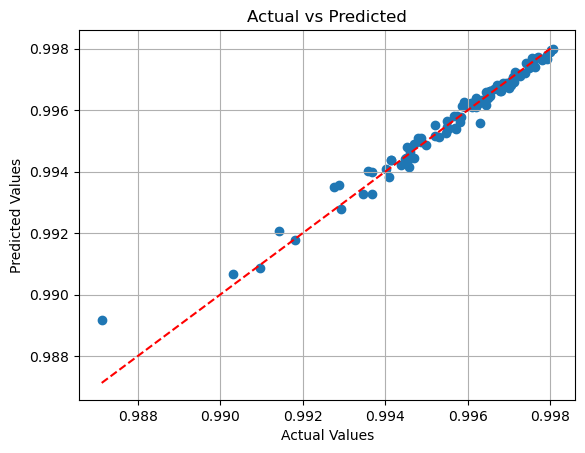

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

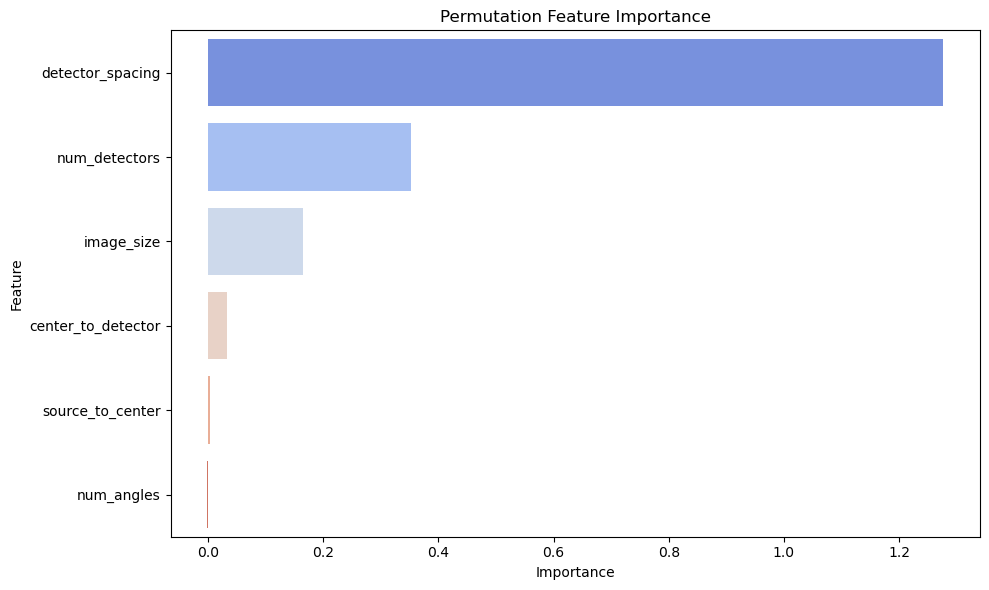

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, scoring='r2')

perm_df = pd.DataFrame({'Feature': X_scaled_df.columns, 'Importance': result.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
result

{'importances_mean': array([ 3.52946508e-01, -1.11598995e-03,  1.64652235e-01,  3.85200185e-03,
         3.26070775e-02,  1.27645384e+00]),
 'importances_std': array([0.06167539, 0.00066813, 0.06724829, 0.00110996, 0.00551184,
        0.17911316]),
 'importances': array([[ 4.32513957e-01,  3.80766360e-01,  3.15041897e-01,
          2.61936557e-01,  2.94103027e-01,  3.89977541e-01,
          3.12687352e-01,  3.90401333e-01,  3.38279831e-01,
          4.67995236e-01,  3.51575825e-01,  2.98716106e-01,
          4.12617760e-01,  3.61037750e-01,  2.21950006e-01,
          5.05176247e-01,  3.21449856e-01,  4.48615619e-01,
          3.64788968e-01,  3.45791542e-01,  2.94680626e-01,
          3.70613518e-01,  2.85939183e-01,  3.70038643e-01,
          3.35557524e-01,  3.49880580e-01,  2.99237631e-01,
          3.10440428e-01,  4.22823951e-01,  3.33760401e-01],
        [-4.96994015e-04, -1.57529081e-03, -2.30346579e-03,
         -5.03043817e-04, -1.30784637e-03, -9.32967246e-04,
         -3.195

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 0.02%


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model_2 = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model_2.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          random_state=42)

In [ ]:
y_pred = model_2.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.0001
MSE: 0.0000
RMSE: 0.0003
R² Score: 0.9809


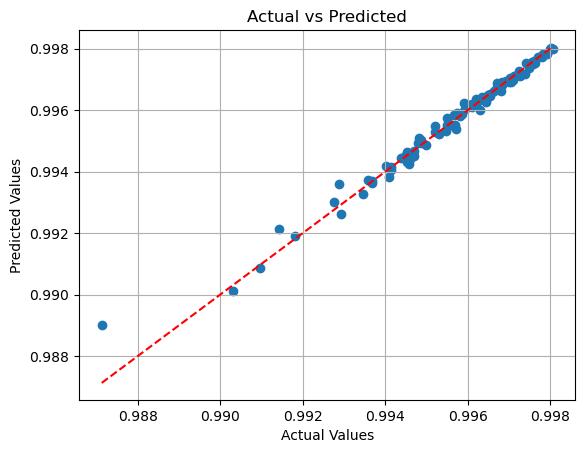

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

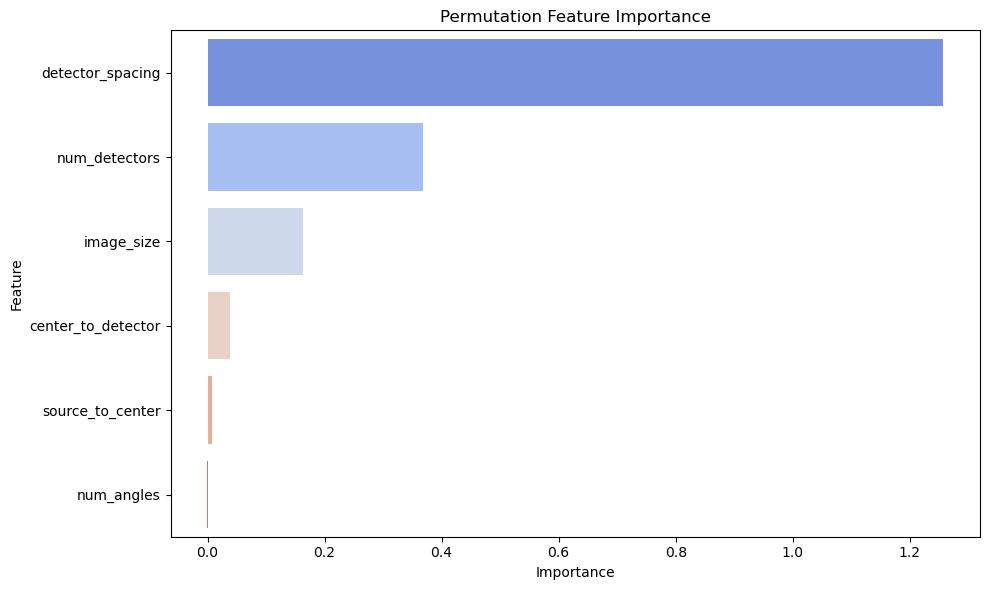

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model_2, X_test, y_test, n_repeats=30, random_state=42, scoring='r2')

perm_df = pd.DataFrame({'Feature': X_scaled_df.columns, 'Importance': result.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='coolwarm')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

model_2.fit(X_train, y_train_scaled)
y_pred_scaled = model_2.predict(X_test)
#y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

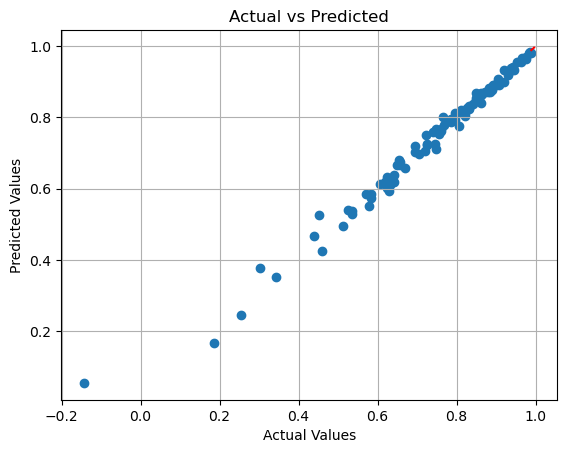

In [ ]:
plt.scatter(y_test_scaled, y_pred_scaled)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

#now we will execute random forest regressor and apply grid search cv for tuning hyperparameters
model = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],         # number of trees
    'max_depth': [None, 10, 20, 30],         # maximum tree depth
    'min_samples_split': [2, 5, 10],         # min samples to split an internal node
    'min_samples_leaf': [1, 2, 4],           # min samples at a leaf node
    'max_features': [1.0, 'sqrt', 'log2'] # number of features considered at each split
}

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 31, 5)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': [1.0, 'sqrt', 'log2']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                                # 5-fold cross-validation
    scoring='neg_mean_squared_error',    # you can also use 'r2'
    n_jobs=-1,                           # use all cores
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,                           # number of parameter combinations to try
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 15, 20, 25, 30],
                                        'max_features': [1.0, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E584F7D5D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E584F65E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E584EFF3D0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
best_model = grid_search.best_estimator_  # or random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)  # or random_search.best_params_
print("Test RMSE:", rmse)
print("Test R2:", r2)

Best Parameters: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Test RMSE: 0.0003034322117574621
Test R2: 0.9721475118754278


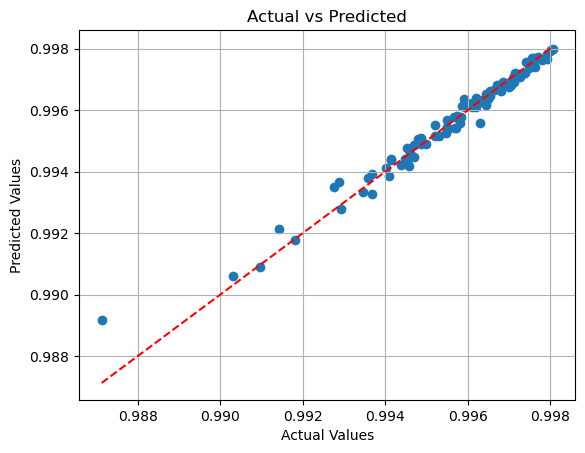

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.grid(True)
plt.show()

In [ ]:
best_model = random_search.best_estimator_  # or random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)  # or random_search.best_params_
print("Test RMSE:", rmse)
print("Test R2:", r2)

Best Parameters: {'max_depth': 15, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 180}
Test RMSE: 0.0003061080181556599
Test R2: 0.9716541135233429
